[View in Colaboratory](https://colab.research.google.com/github/ankanbhunia/Colab/blob/master/Untitled1.ipynb)

In [0]:
import re
import shutil
import tensorflow as tf
from __future__ import division
import matplotlib.pyplot as plt

MP_NAME = 'mp'

params = {'batch_size' : 1,
          'train_log' : 'train_log4',
          'model_dir' : 'model4',
          'output_dir' : 'output',
          'log_device_placement' : False,
          'data_train_gt' : '/content/Data_original/Data_gt/train_gt/',
          'data_train_im' : '/content/Data_original/Data_im/train_im/',
          'data_train_index' : '/content/Data_original/dir_name.txt',
          'num_epochs_per_decay' : 20,
          'learning_rate_per_decay' : 0.9,
          'initial_learning_rate' :1.0e-1
          
          
          
    
}

In [0]:
def _activation_summary(x):

    tensor_name = re.sub('%s_[0-9]*/' % MP_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):

    with tf.device('/gpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer)

    return var


def _variable_with_weight_decay(name, shape, stddev, wd):

    var = _variable_on_cpu(name, shape, tf.random_normal_initializer(stddev=stddev))
    if wd:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)

    return var


class BatchNorm(object):

    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):

        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):

        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None,
                                            epsilon=self.epsilon, scale=True, scope=self.name)


def multi_scale_block(in_con, in_dim, out_dim, is_bn=False):

    with tf.variable_scope('con_9') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[9, 9, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_9 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_9)

    with tf.variable_scope('con_7') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[7, 7, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_7 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_7)

    with tf.variable_scope('con_5') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_5 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_5)

    with tf.variable_scope('con_3') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[3, 3, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_3 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_3)

    with tf.variable_scope('concat') as scope:
        concat = tf.concat([con_9, con_7, con_5, con_3], 3, name=scope.name)
        biases = _variable_on_cpu('biases', [out_dim * 4], tf.constant_initializer(0))
        bias = tf.nn.bias_add(concat, biases)

        if is_bn:
            bn = BatchNorm()
            bias = bn(bias)

        msb = tf.nn.relu(bias)
        _activation_summary(msb)

    return msb



def inference_bn(images):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('con1') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[9, 9, 3, 64],
                                                 stddev=0.01, wd=0.0005)
            con = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            con1 = tf.nn.relu(bias)
            _activation_summary(con1)

        # msb_con2
        with tf.variable_scope('msb_con2'):
            msb_con2 = multi_scale_block(con1, 64, 16, is_bn=True)

        # pool_msb_con2
        with tf.variable_scope('pool_msb_con2') as scope:
            pool_msb_con2 = tf.nn.max_pool(msb_con2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con3
        with tf.variable_scope('msb_con3'):
            msb_con3 = multi_scale_block(pool_msb_con2, 64, 32, is_bn=True)

        # msb_con4
        with tf.variable_scope('msb_con4'):
            msb_con4 = multi_scale_block(msb_con3, 128, 32, is_bn=True)

        # pool_msb_con4
        with tf.variable_scope('pool_msb_con4') as scope:
            pool_msb_con4 = tf.nn.max_pool(msb_con4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con5
        with tf.variable_scope('msb_con5'):
            msb_con5 = multi_scale_block(pool_msb_con4, 128, 64, is_bn=True)

        # msb_con6
        with tf.variable_scope('msb_con6'):
            msb_con6 = multi_scale_block(msb_con5, 256, 64, is_bn=True)

        # mpl_con7
        with tf.variable_scope('mpl_con7') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 256, 1000], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(msb_con6, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1000], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            mpl_con7 = tf.nn.relu(bias)
            _activation_summary(mpl_con7)

        # con_out
        with tf.variable_scope('con_out') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 1000, 1], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(mpl_con7, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)

            bn = BatchNorm()
            bias = bn(bias)

            con_out = tf.nn.relu(tf.nn.sigmoid(bias))
            _activation_summary(con_out)

        image_out = con_out

        tf.summary.image("con_img", image_out)

        return image_out


def get_loss(predict, label):

    l2_loss = tf.reduce_sum((predict - label) * (predict - label))

    tf.summary.histogram('loss', l2_loss)

    return l2_loss


def add_avg_loss(avg_loss):

    add_avg_loss_op = avg_loss * 1
    tf.summary.histogram('avg_loss', avg_loss)

    return add_avg_loss_op


def _add_loss_summaries(total_loss):

    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    for l in losses + [total_loss]:
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op


def train(total_loss, global_step, nums_per_train):

    num_batches_per_epoch = nums_per_train / params['batch_size']
    decay_steps = int(num_batches_per_epoch * params['num_epochs_per_decay'])

    lr = tf.train.exponential_decay(params['initial_learning_rate'],
                                    global_step,
                                    decay_steps,
                                    params['learning_rate_per_decay'],
                                    staircase=True)
    tf.summary.scalar('learning_rate', lr)

  
    opt = tf.train.RMSPropOptimizer(lr)
    grads = opt.compute_gradients(total_loss)


    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
    train_op = apply_gradient_op

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    return train_op

In [0]:
class batch_norm(object):
            # h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, self.df_dim*2, name='d_h1_conv'),decay=0.9,updates_collections=None,epsilon=0.00001,scale=True,scope="d_h1_conv"))
    def __init__(self, epsilon=0.001, momentum = 0, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None, epsilon=self.epsilon, scale=True, scope=self.name)

def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=1, d_w=1, stddev=0.02,
           name="conv2d",relu = True, bn = True):
    
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)
        if relu:
            conv  = tf.nn.relu(conv)
        if bn:
            bnF = batch_norm(name = name+'_bn')
            conv = bnF(conv)
        
        return conv

In [0]:
def inference_bn_(Input):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('Branch1') as scope:

            Branch1_conv1 = conv2d(Input, 16, 9, 9, name = 'conv1')
            Branch1_pool1 = tf.layers.max_pooling2d(Branch1_conv1, 2, 2, padding = 'same')
            Branch1_conv2 = conv2d(Branch1_pool1, 32, 7, 7, name = 'conv2')
            Branch1_pool2 = tf.layers.max_pooling2d(Branch1_conv2, 2, 2, padding = 'same')
            Branch1_conv3 = conv2d(Branch1_pool2, 16, 7, 7, name = 'conv3')
            Branch1_conv4 = conv2d(Branch1_conv3, 8, 7, 7, name = 'conv4')

        with tf.variable_scope('Branch2') as scope:

            Branch2_conv1 = conv2d(Input, 20, 7, 7, name = 'conv1')
            Branch2_pool1 = tf.layers.max_pooling2d(Branch2_conv1, 2, 2, padding = 'same')
            Branch2_conv2 = conv2d(Branch2_pool1, 40, 5, 5, name = 'conv2')
            Branch2_pool2 = tf.layers.max_pooling2d(Branch2_conv2, 2, 2, padding = 'same')
            Branch2_conv3 = conv2d(Branch2_pool2, 20, 5, 5, name = 'conv3')
            Branch2_conv4 = conv2d(Branch2_conv3, 10, 5, 5, name = 'conv4')

        with tf.variable_scope('Branch3') as scope:

            Branch3_conv1 = conv2d(Input, 24, 5, 5, name = 'conv1')
            Branch3_pool1 = tf.layers.max_pooling2d(Branch3_conv1, 2, 2, padding = 'same')
            Branch3_conv2 = conv2d(Branch3_pool1, 48, 3, 3, name = 'conv2')
            Branch3_pool2 = tf.layers.max_pooling2d(Branch3_conv2, 2, 2, padding = 'same')
            Branch3_conv3 = conv2d(Branch3_pool2, 24, 3, 3, name = 'conv3')
            Branch3_conv4 = conv2d(Branch3_conv3, 12, 3, 3, name = 'conv4')

        with tf.variable_scope('fuse') as scope:

            Fuse = tf.concat([Branch1_conv4, Branch2_conv4, Branch3_conv4],-1)
            Out = conv2d(Fuse, 1, 1, 1, name = 'Out')

        return tf.nn.relu(tf.nn.sigmoid(Out))

In [0]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def inf(x):
  
  
  with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):
    
      # s net ###########################################################
      w_conv1_1 = tf.get_variable('w_conv1_1', [5, 5, 3, 24])
      b_conv1_1 = tf.get_variable('b_conv1_1', [24])
      h_conv1_1 = tf.nn.relu(conv2d(x, w_conv1_1) + b_conv1_1)

      h_pool1_1 = max_pool_2x2(h_conv1_1)

      w_conv2_1 = tf.get_variable('w_conv2_1', [3, 3, 24, 48])
      b_conv2_1 = tf.get_variable('b_conv2_1', [48])
      h_conv2_1 = tf.nn.relu(conv2d(h_pool1_1, w_conv2_1) + b_conv2_1)

      h_pool2_1 = max_pool_2x2(h_conv2_1)

      w_conv3_1 = tf.get_variable('w_conv3_1', [3, 3, 48, 24])
      b_conv3_1 = tf.get_variable('b_conv3_1', [24])
      h_conv3_1 = tf.nn.relu(conv2d(h_pool2_1, w_conv3_1) + b_conv3_1)

      w_conv4_1 = tf.get_variable('w_conv4_1', [3, 3, 24, 12])
      b_conv4_1 = tf.get_variable('b_conv4_1', [12])
      h_conv4_1 = tf.nn.relu(conv2d(h_conv3_1, w_conv4_1) + b_conv4_1)

      # m net ###########################################################
      w_conv1_2 = tf.get_variable('w_conv1_2', [7, 7, 3, 20])
      b_conv1_2 = tf.get_variable('b_conv1_2', [20])
      h_conv1_2 = tf.nn.relu(conv2d(x, w_conv1_2) + b_conv1_2)

      h_pool1_2 = max_pool_2x2(h_conv1_2)

      w_conv2_2 = tf.get_variable('w_conv2_2', [5, 5, 20, 40])
      b_conv2_2 = tf.get_variable('b_conv2_2', [40])
      h_conv2_2 = tf.nn.relu(conv2d(h_pool1_2, w_conv2_2) + b_conv2_2)

      h_pool2_2 = max_pool_2x2(h_conv2_2)

      w_conv3_2 = tf.get_variable('w_conv3_2', [5, 5, 40, 20])
      b_conv3_2 = tf.get_variable('b_conv3_2', [20])
      h_conv3_2 = tf.nn.relu(conv2d(h_pool2_2, w_conv3_2) + b_conv3_2)

      w_conv4_2 = tf.get_variable('w_conv4_2', [5, 5, 20, 10])
      b_conv4_2 = tf.get_variable('b_conv4_2', [10])
      h_conv4_2 = tf.nn.relu(conv2d(h_conv3_2, w_conv4_2) + b_conv4_2)

      # l net ###########################################################
      w_conv1_3 = tf.get_variable('w_conv1_3', [9, 9, 3, 16])
      b_conv1_3 = tf.get_variable('b_conv1_3', [16])
      h_conv1_3 = tf.nn.relu(conv2d(x, w_conv1_3) + b_conv1_3)

      h_pool1_3 = max_pool_2x2(h_conv1_3)

      w_conv2_3 = tf.get_variable('w_conv2_3', [7, 7, 16, 32])
      b_conv2_3 = tf.get_variable('b_conv2_3', [32])
      h_conv2_3 = tf.nn.relu(conv2d(h_pool1_3, w_conv2_3) + b_conv2_3)

      h_pool2_3 = max_pool_2x2(h_conv2_3)

      w_conv3_3 = tf.get_variable('w_conv3_3', [7, 7, 32, 16])
      b_conv3_3 = tf.get_variable('b_conv3_3', [16])
      h_conv3_3 = tf.nn.relu(conv2d(h_pool2_3, w_conv3_3) + b_conv3_3)

      w_conv4_3 = tf.get_variable('w_conv4_3', [7, 7, 16, 8])
      b_conv4_3 = tf.get_variable('b_conv4_3', [8])
      h_conv4_3 = tf.nn.relu(conv2d(h_conv3_3, w_conv4_3) + b_conv4_3)

      # merge ###########################################################
      h_conv4_merge = tf.concat([h_conv4_1, h_conv4_2, h_conv4_3], 3)

      w_conv5 = tf.get_variable('w_conv5', [1, 1, 30, 1])
      b_conv5 = tf.get_variable('b_conv5', [1])
      h_conv5 = conv2d(h_conv4_merge, w_conv5) + b_conv5

      y_pre = h_conv5

      return y_pre

In [33]:
tf.reset_default_graph()
inf(tf.placeholder(tf.float32, [None,257,257,3]))

<tf.Tensor 'Network/add_12:0' shape=(?, 65, 65, 1) dtype=float32>

INFO:tensorflow:Restoring parameters from model4/skip_mcnn.ckpt-0
##0 >> avg_loss:3917.8281250	 GT:1546.0002441	 predict:13592.4375000


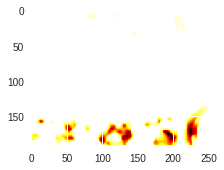

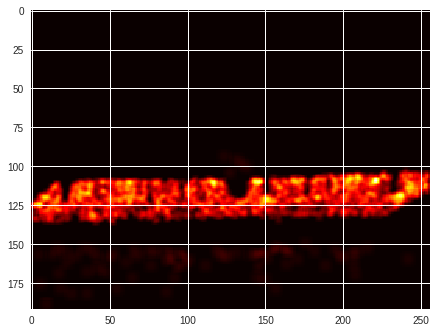

##100 >> avg_loss:23.9124241	 GT:298.0000610	 predict:1053.4582520


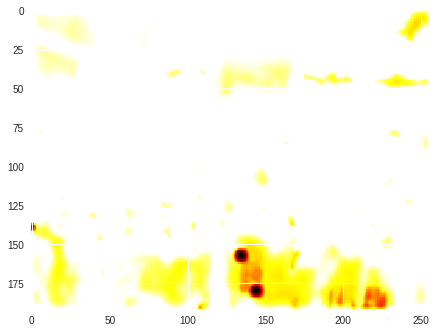

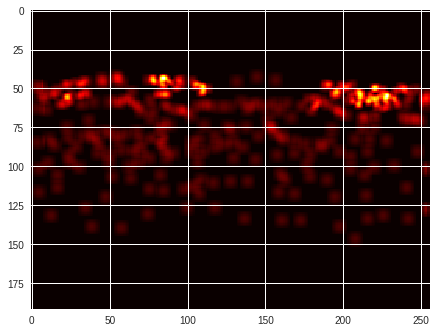

##200 >> avg_loss:25.0029926	 GT:444.9999695	 predict:401.3497314


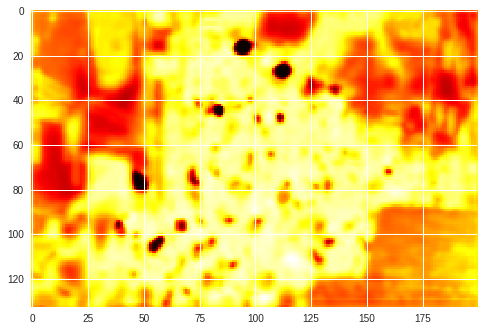

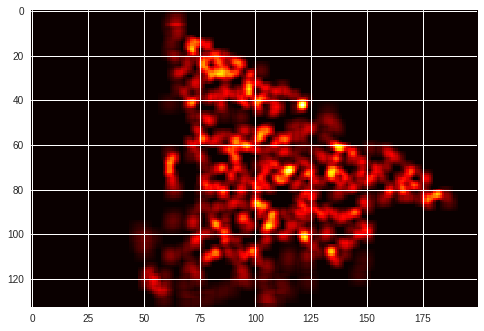

##300 >> avg_loss:25.2124329	 GT:233.0000916	 predict:707.6130981


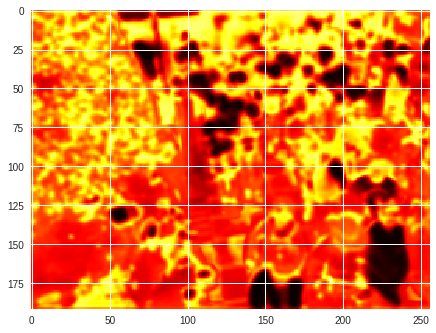

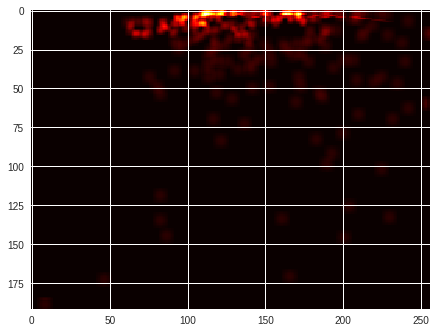

##400 >> avg_loss:2.2438741	 GT:83.0000992	 predict:193.2082672


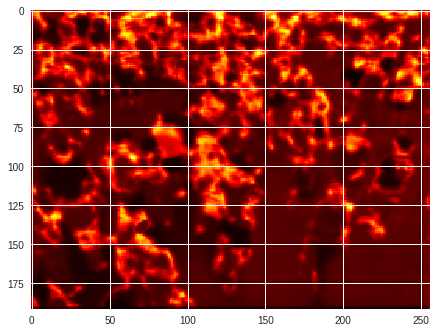

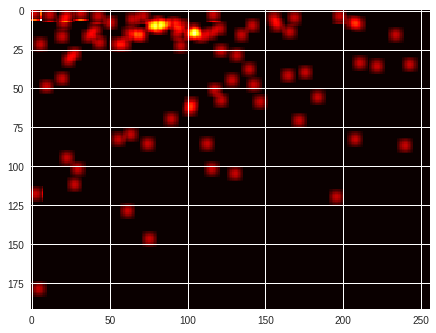

##500 >> avg_loss:5.4428687	 GT:29.9999809	 predict:153.6363678


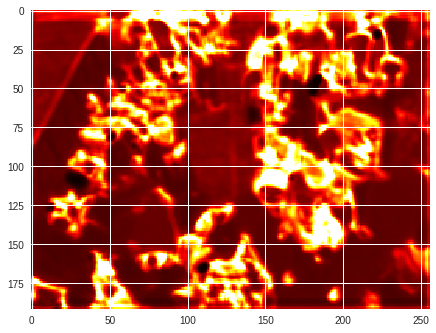

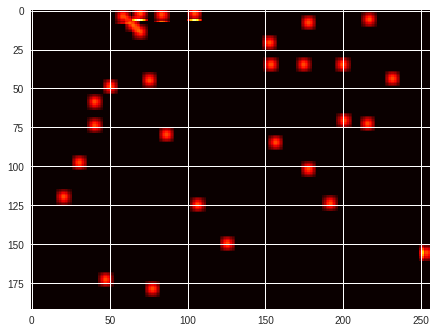

##600 >> avg_loss:1.3244878	 GT:87.0000153	 predict:131.1077423


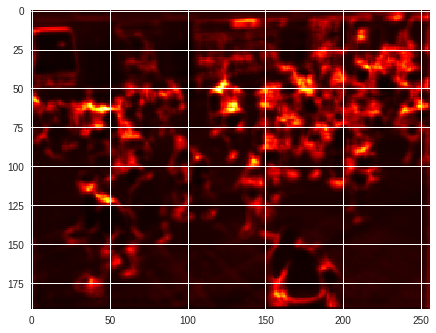

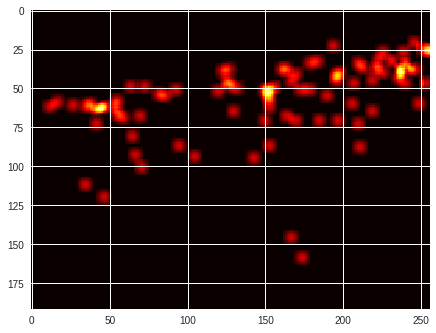

##700 >> avg_loss:388.1920166	 GT:1546.0002441	 predict:193.7251129


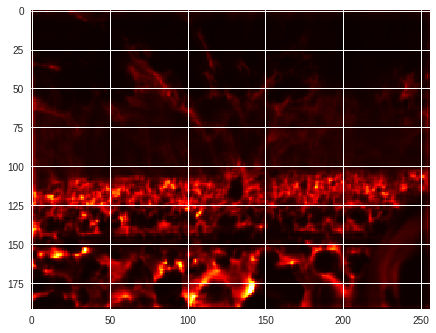

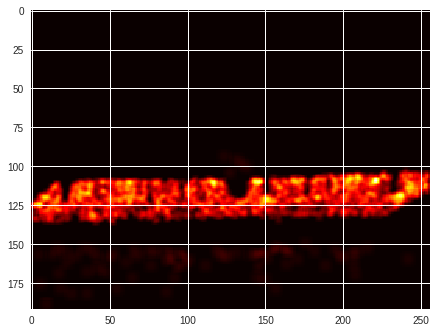

##800 >> avg_loss:11.7372580	 GT:298.0000610	 predict:574.2344971


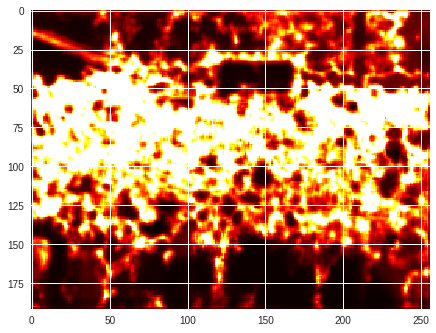

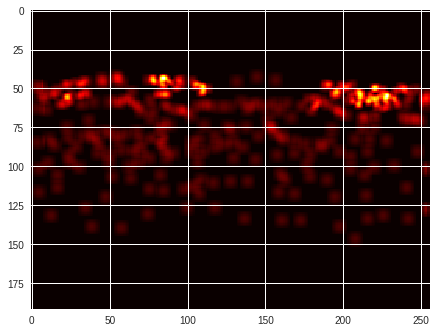

##900 >> avg_loss:18.5987072	 GT:444.9999695	 predict:396.5227051


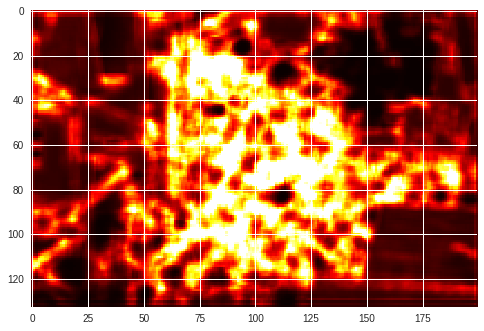

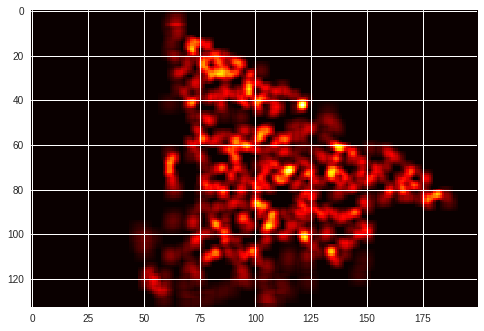

##1000 >> avg_loss:30.8788490	 GT:233.0000916	 predict:680.1674805


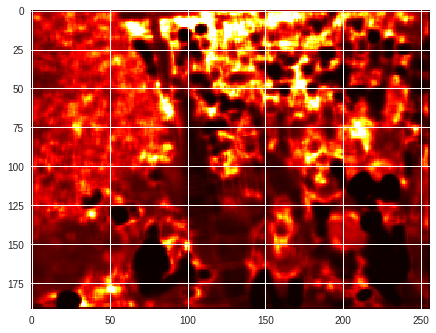

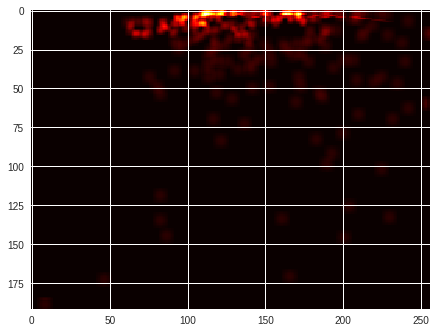

##1100 >> avg_loss:1.9848367	 GT:83.0000992	 predict:185.4731140


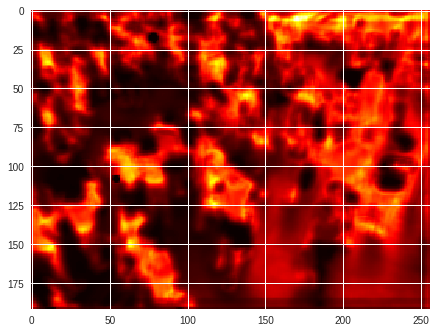

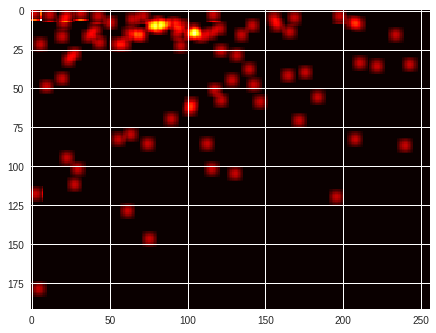

##1200 >> avg_loss:4.9428859	 GT:29.9999809	 predict:166.6840973


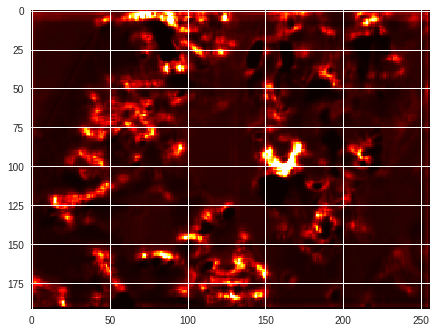

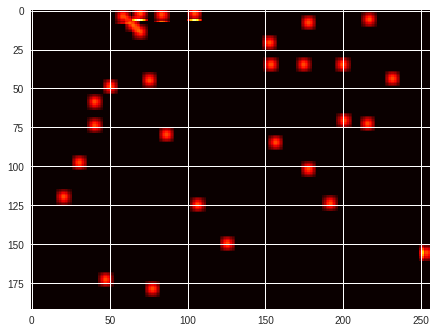

##1300 >> avg_loss:1.1304313	 GT:87.0000153	 predict:136.0230713


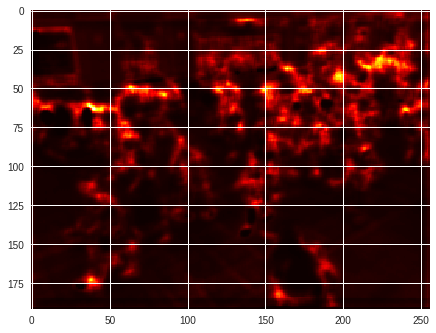

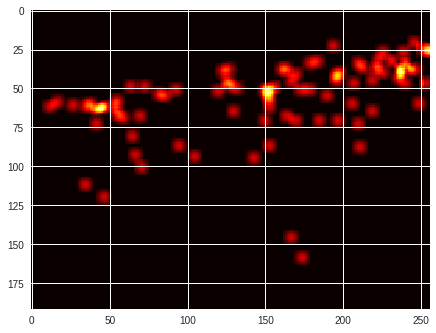

##1400 >> avg_loss:386.8934937	 GT:1546.0002441	 predict:196.0578766


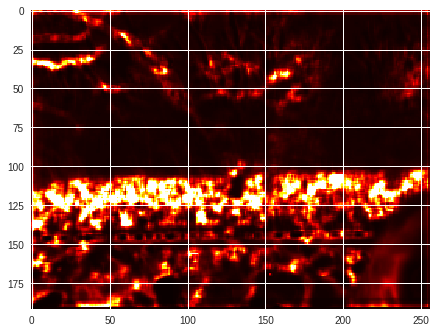

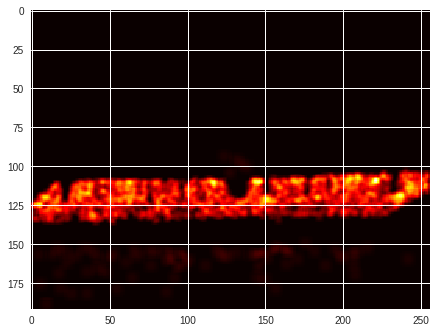

##1500 >> avg_loss:12.8772602	 GT:298.0000610	 predict:508.5444946


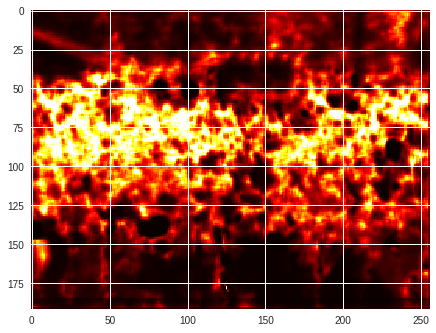

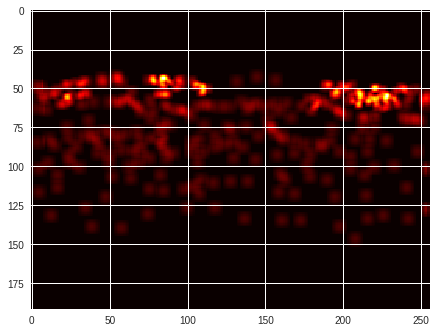

##1600 >> avg_loss:18.2524948	 GT:444.9999695	 predict:386.5126648


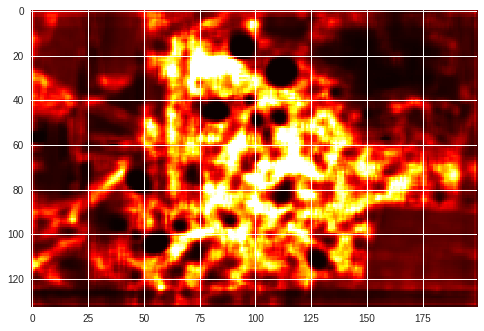

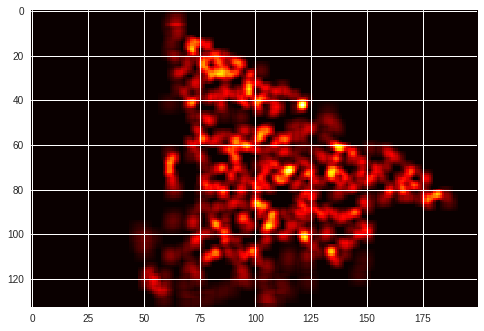

##1700 >> avg_loss:23.3804569	 GT:233.0000916	 predict:651.5877686


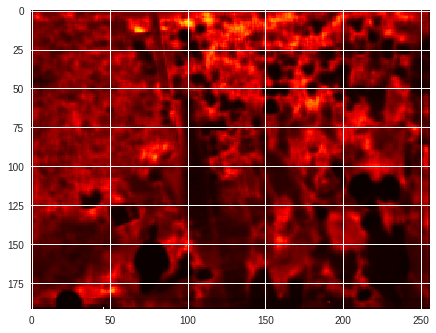

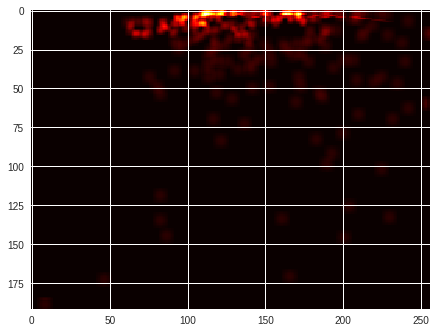

##1800 >> avg_loss:1.5532355	 GT:83.0000992	 predict:174.0550995


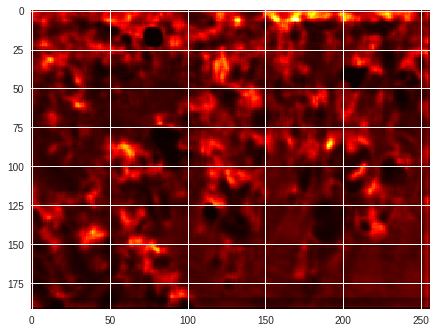

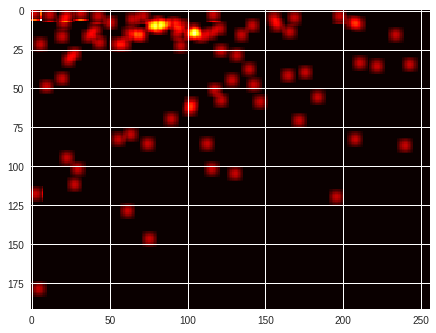

##1900 >> avg_loss:2.7992687	 GT:29.9999809	 predict:185.2979584


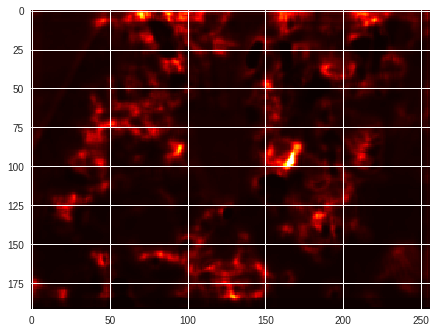

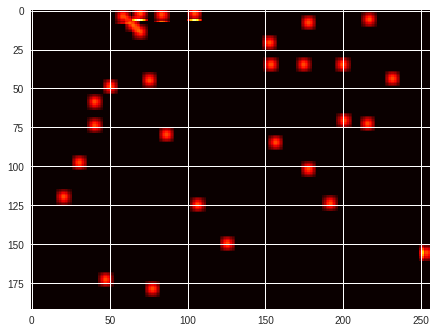

##2000 >> avg_loss:1.1132812	 GT:87.0000153	 predict:134.8571472


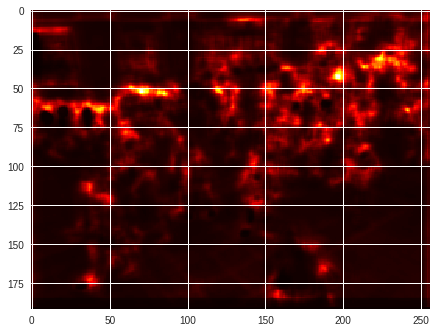

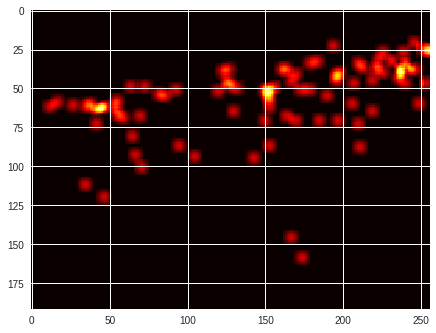

##2100 >> avg_loss:381.1667480	 GT:1546.0002441	 predict:244.9928284


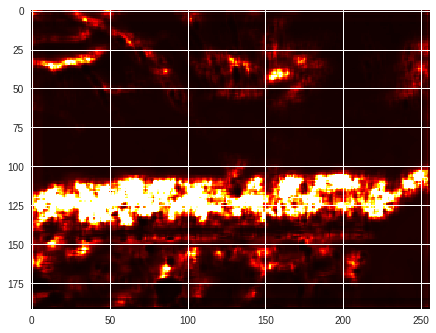

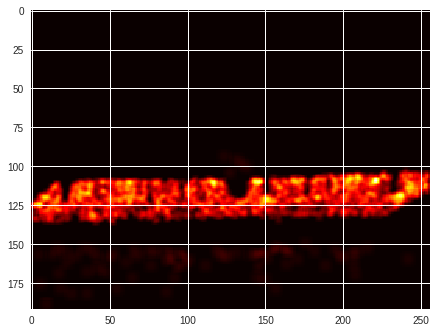

##2200 >> avg_loss:10.3791275	 GT:298.0000610	 predict:514.8744507


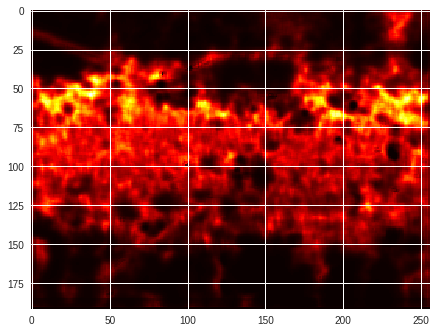

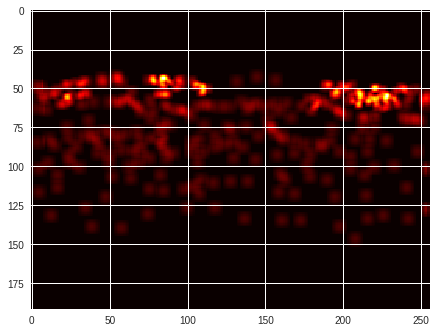

##2300 >> avg_loss:17.6120987	 GT:444.9999695	 predict:368.1728210


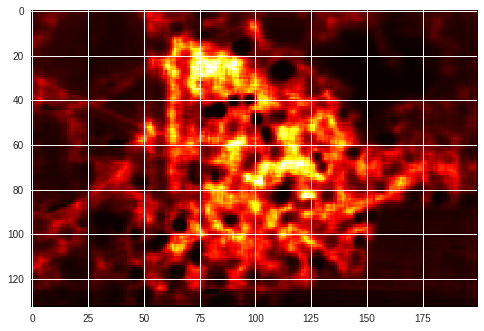

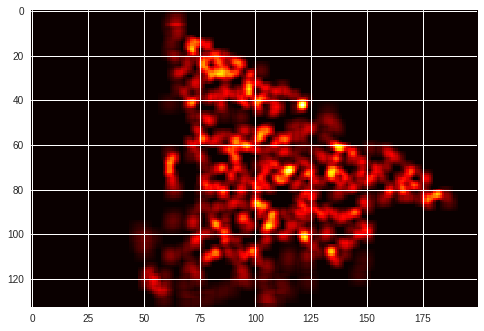

##2400 >> avg_loss:21.9151230	 GT:233.0000916	 predict:674.0082397


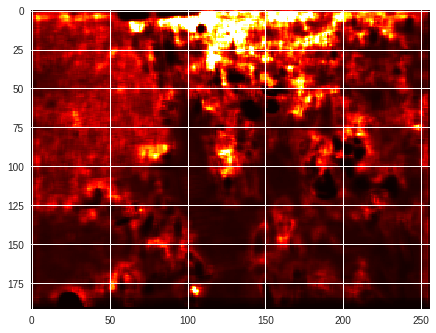

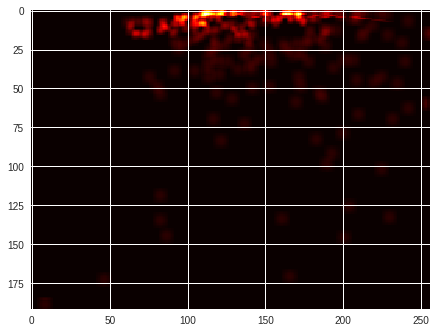

##2500 >> avg_loss:1.9470921	 GT:83.0000992	 predict:170.9216461


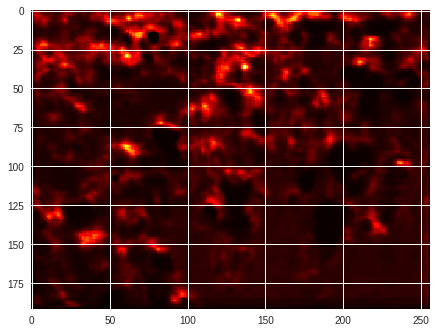

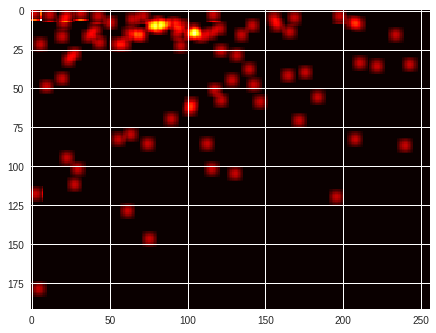

##2600 >> avg_loss:2.7755556	 GT:29.9999809	 predict:171.5157776


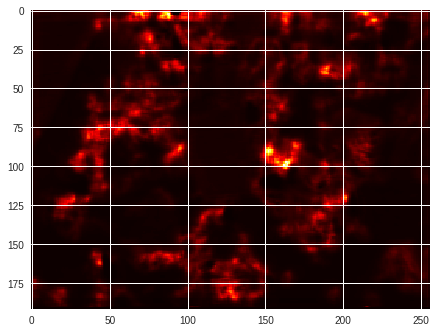

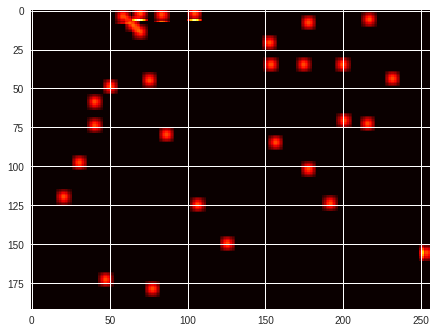

##2700 >> avg_loss:1.0541768	 GT:87.0000153	 predict:127.9335175


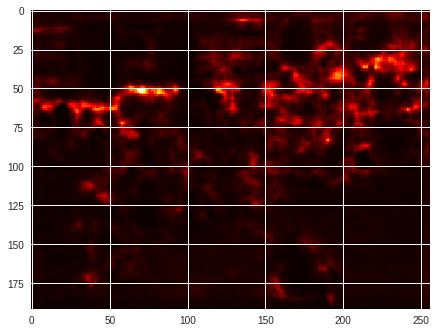

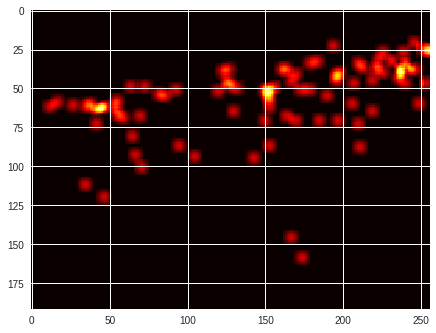

##2800 >> avg_loss:373.7664795	 GT:1546.0002441	 predict:353.2828979


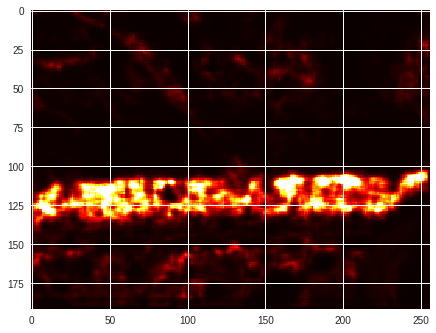

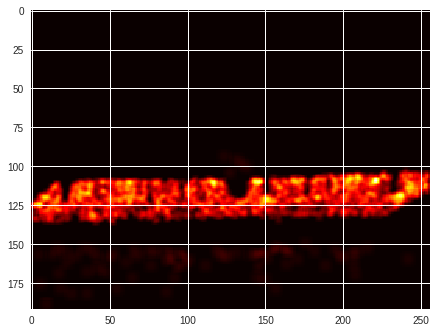

##2900 >> avg_loss:8.6788445	 GT:298.0000610	 predict:429.2505798


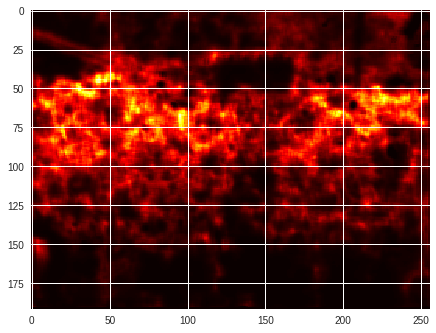

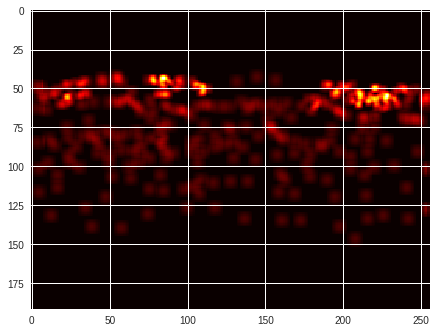

##3000 >> avg_loss:16.7370872	 GT:444.9999695	 predict:405.5686340


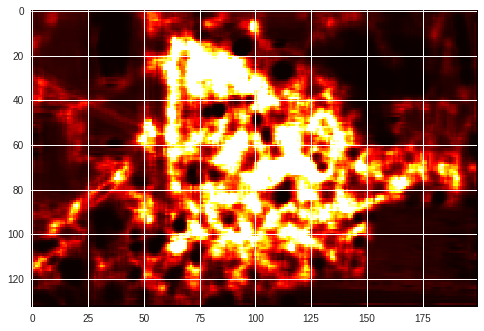

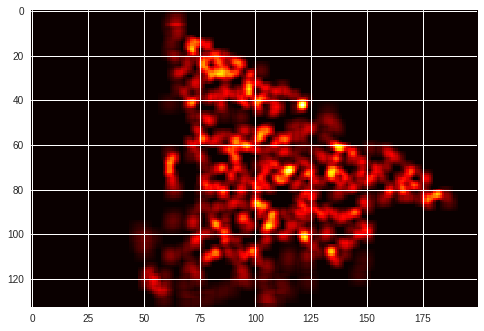

##3100 >> avg_loss:20.1360683	 GT:233.0000916	 predict:664.8464966


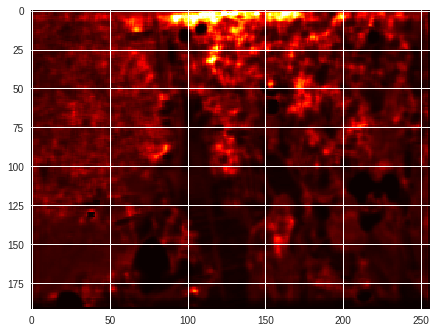

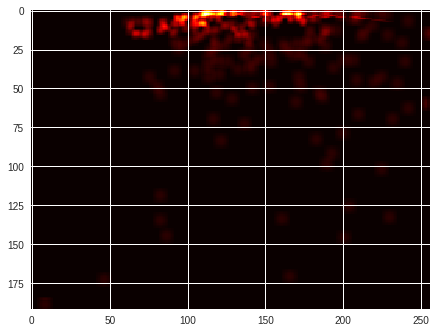

##3200 >> avg_loss:1.4722980	 GT:83.0000992	 predict:159.7473297


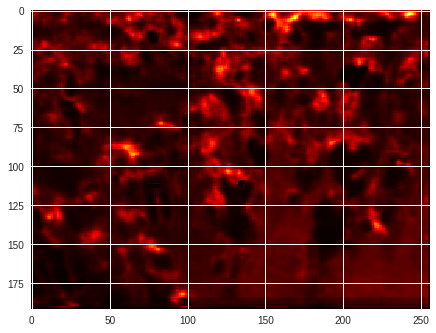

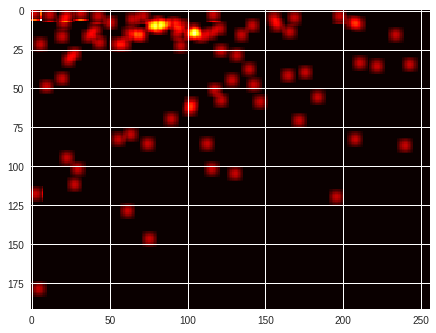

##3300 >> avg_loss:1.6911850	 GT:29.9999809	 predict:151.4569397


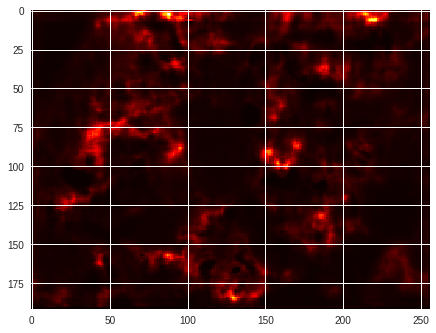

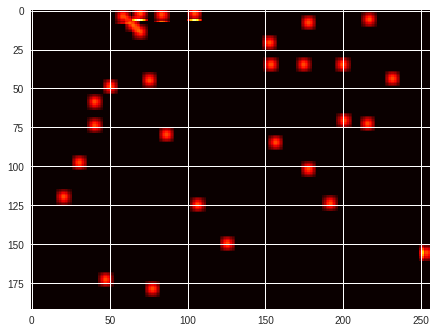

##3400 >> avg_loss:1.1586785	 GT:87.0000153	 predict:125.7771683


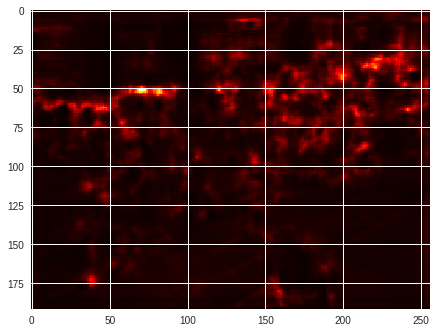

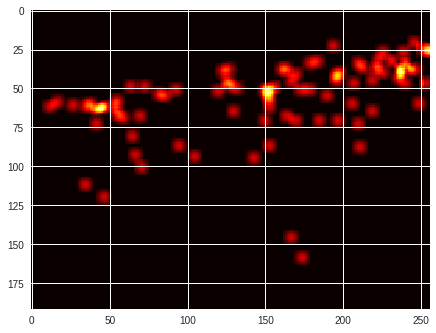

##3500 >> avg_loss:374.9622803	 GT:1546.0002441	 predict:385.1488037


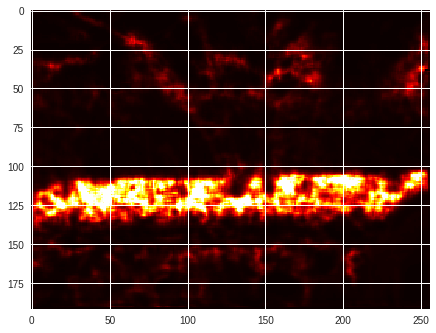

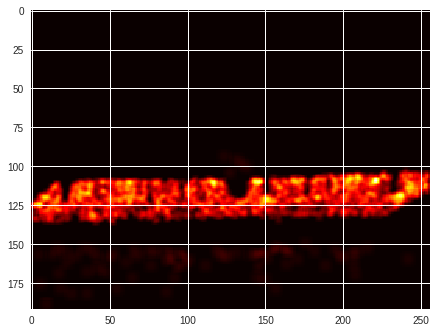

##3600 >> avg_loss:9.8997498	 GT:298.0000610	 predict:437.8250732


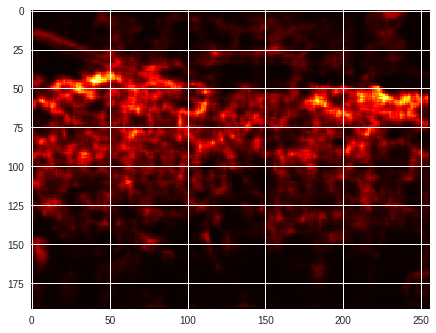

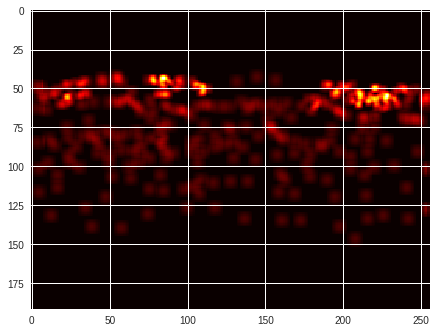

##3700 >> avg_loss:18.8542385	 GT:444.9999695	 predict:355.9598694


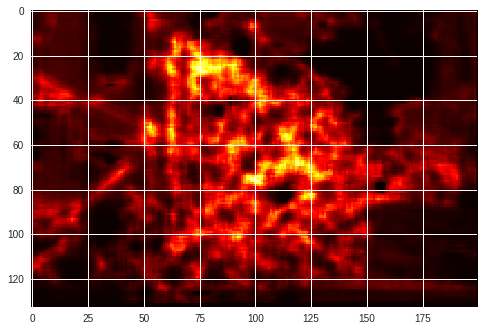

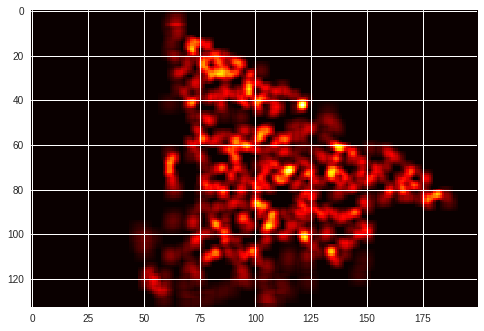

##3800 >> avg_loss:21.6205940	 GT:233.0000916	 predict:575.7174072


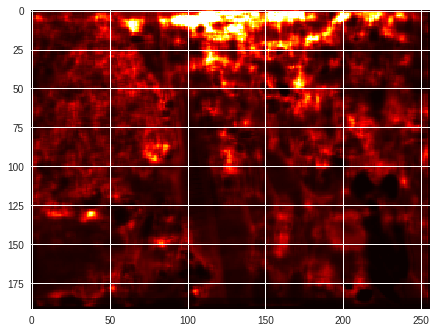

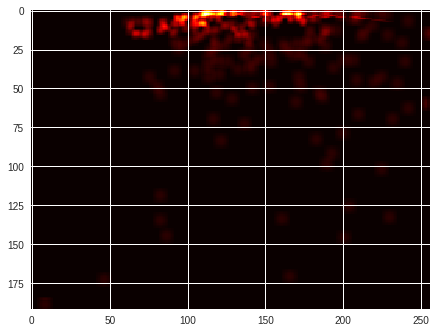

##3900 >> avg_loss:1.4606993	 GT:83.0000992	 predict:158.7976074


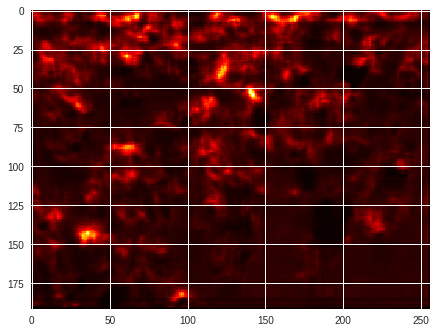

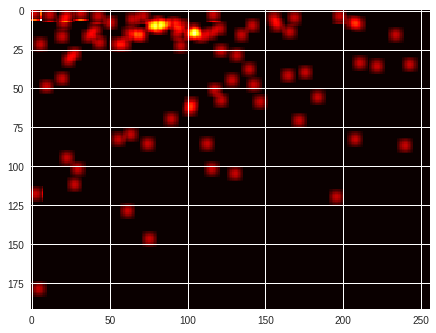

##4000 >> avg_loss:1.0372524	 GT:29.9999809	 predict:132.4275055


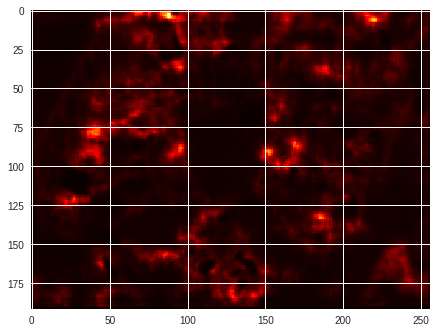

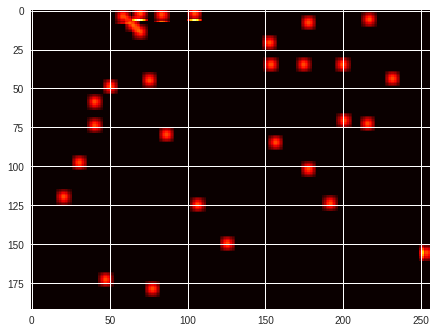

##4100 >> avg_loss:1.2390208	 GT:87.0000153	 predict:131.2852631


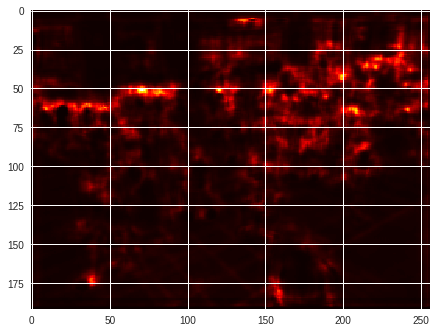

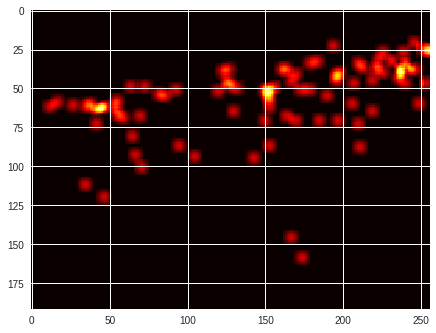

In [0]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[None,None,None,3])
        label = tf.placeholder("float",[None,None,None,1])
        avg_loss = tf.placeholder("float")

        predicts = inference_bn_(image)  
        loss = get_loss(predicts, label)  
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)
        
        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            if step < nums_train * 10:
               
                num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
            else:
               
                num_batch = random.sample(range(nums_train), nums_train)[0:params['batch_size']]

            xs, ys = [], []
            for index in num_batch:
                
                file_name = dir_name[index]
                im_name, gt_name = file_name.split(' ')
                gt_name = gt_name.split('\n')[0]

               
                batch_xs = cv2.imread(params['data_train_im'] + im_name)
                batch_xs = (np.array(batch_xs, dtype=np.float32))

                
                batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
                batch_ys = np.array(batch_ys, dtype=np.float32)
                batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

                xs.append(batch_xs)
                ys.append(batch_ys)
                
            np_xs = np.array(xs)
            np_ys = np.array(ys)
  
         
            _, loss_value = sess.run([train_op, loss], feed_dict={image: np_xs, label: np_ys})
            output = sess.run(predicts, feed_dict={image: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0
            
            if step % 100 == 0:
                print("##"+str(step)+" >> avg_loss:%.7f\t GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys))), sum(sum(sum(output)))))
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                
                fig.add_subplot(211)
             
                plt.imshow(output[0,:,:,0], cmap = 'hot')
                plt.show()
                
                
                fig.add_subplot(212) 
                plt.imshow(np_ys[0,:,:,0], cmap = 'hot')
                plt.show()
               
              

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        gfile.DeleteRecursively(params['train_log'])
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()


In [0]:
def get_ranking_loss(counts, counts_gt):
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(9), 2):
        ranking_loss = ranking_loss + _ranking_loss_(counts[i], counts[j], counts_gt[i], counts_gt[j])
    
    return ranking_loss

In [50]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np





def Compile():

    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[None,None,None,3])
        label = tf.placeholder("float",[None,None,None,1])
        avg_loss = tf.placeholder("float")
        
        W = tf.placeholder(tf.int32)
        H = tf.placeholder(tf.int32)
        
        losses = []
        densities = []
        gt_densities = []
        counts = []
        counts_gt = []
        
        MAEs = []
        MSEs = []
        
        for i in range(9):
            
            randw = np.random.random()
            randh = np.random.random()
            
            W0 = tf.cast(randw*tf.cast(W-W//4, tf.float32),tf.int32)
            H0 = tf.cast(randh*tf.cast(H-H//4, tf.float32),tf.int32)

            patch_img = image[:,W0:W0+W//4,H0:H0+H//4,:]
            patch_lab = label[:,W0//4:W0//4+tf.cast(tf.ceil((W//4)/4),tf.int32),H0//4:H0//4+tf.cast(tf.ceil((H//4)/4),tf.int32),:]
        
            patch_density = inf(patch_img)
            
            patch_count = tf.reduce_sum(patch_density)
            
            tf.summary.image('lab'+str(i+1),patch_lab,1)
            tf.summary.image('out'+str(i+1),patch_density,1)
            
            patch_count_gt = tf.reduce_sum(patch_lab)
            
            MAE_ = tf.abs(patch_count - patch_count_gt)
            MSE_ = tf.square(patch_count - patch_count_gt)
        
            losses.append(get_loss(patch_density, patch_lab))

            
            densities.append(patch_density)
            gt_densities.append(patch_lab)
            
            counts.append(patch_count)
            counts_gt.append(patch_count_gt)
            
            MAEs.append(MAE_)
            MSEs.append(MSE_)
            
            
        MAE = tf.reduce_sum(MAEs)
        MSE = tf.reduce_sum(MSEs)
        
        ranking_loss = get_ranking_loss(counts, counts_gt)
        

        loss = tf.reduce_sum(losses) +  100 * ranking_loss
        train_op = train(loss, global_step, nums_train)  
        
        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0
        
        _MAE_ = 0
        _MSE_ = 0

        for step in xrange(steps):
            if step < nums_train * 10:
               
                num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
            else:
               
                num_batch = random.sample(range(nums_train), nums_train)[0:params['batch_size']]

            xs, ys = [], []
            for index in num_batch:
                
                file_name = dir_name[index]
                im_name, gt_name = file_name.split(' ')
                gt_name = gt_name.split('\n')[0]

               
                batch_xs = cv2.imread(params['data_train_im'] + im_name)
                batch_xs = (np.array(batch_xs, dtype=np.float32))

                
                batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
                batch_ys = np.array(batch_ys, dtype=np.float32)
                batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

                xs.append(batch_xs)
                ys.append(batch_ys)
                
            np_xs = np.array(xs)
            np_ys = np.array(ys)
  
            _,w,h,_ = np_xs.shape
            _, loss_value, ranking_loss_, MAE_metric, MSE_metric = sess.run([train_op, loss, ranking_loss, MAE, MSE], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            output, _label = sess.run([densities, gt_densities], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            avg_loss_1 += loss_value
            _MAE_ += MAE_metric
            _MSE_ += MSE_metric
            
            if step % 500 == 0:
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 500, W:w , H:h})
                summary_writer.add_summary(summary_str, step)
                print ('')
                print ('#############################################')
                print ('')
                print ('## Step : ' + str(step) + ' Train MAE : ' + str(_MAE_/500) + ' Train MSE : ' + str(np.sqrt(_MSE_/500)))
                print ('')
                print ('#############################################')
                print ('')
                avg_loss_1 = 0
                _MAE_ = 0
                _MSE_ = 0
            
            if step % 100 == 0:
                print("## Step : " +str(step)+" avg_loss:%.7f\t GT:%.7f\t predict:%.7f" % \
                      (loss_value, np.sum(np.array(_label)), np.sum(np.array(output))))
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value, W:w , H:h})
       
                plt.imshow(np.concatenate([output[0][0,:,:,0], _label[0][0,:,:,0]],1),cmap = 'hot')
                plt.show()

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            #if step % 500 == 0:
             #   out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
              #  np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()

TypeError: ignored

In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
tf.reset_default_graph()

In [10]:
!ls

shutil.rmtree(params['train_log'],ignore_errors=True)

Colabstart.py	gdfuse.zip	ngrok			      train_log4
datalab		Init.ipynb	ngrok-stable-linux-amd64.zip  trash.py
DLSETUP_.ipynb	localtunnel.rb	output
drive		model2		starting_script.ipynb
